In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

# Can you predict wine variety based on desciption?

## Importing & Cleaning the data

I imported the data and only kept the most interesting features. While I'm going to start predicting wine variety with description, I'm keeping some of the other attributes of the wine (price ,points, region, province, winery, country) as potentials outcomes and features to potentially explore later.

In [15]:
df = pd.read_csv('/Users/rsylvetsky/downloads/wine-reviews/winemag-data-130k-v2.csv')
df = df[['country', 'description','points','price','province', 'region_1','region_2','variety','title','winery']]

I read that this dataset had some duplicates, so I wanted to see just how many and I decided to drop all duplicate descriptions

In [16]:
df[df.duplicated(subset='description') == True].count()


country        10012
description    10016
points         10016
price           9408
province       10012
region_1        8327
region_2        3751
variety        10016
title          10016
winery         10016
dtype: int64

In [17]:
df_cln = df.drop_duplicates(subset= 'description')

In [18]:
df_cln.dtypes

country         object
description     object
points           int64
price          float64
province        object
region_1        object
region_2        object
variety         object
title           object
winery          object
dtype: object

### Below is the Data Dictionary for this analysis
Variable | Description | Type of Variable
---| ---| ---
country | name of the country of origin of wine | string
description | sommelier's description of wine | string
points | point score of wine given by sommelier. between 80 and 100 | discrete 
price | the price of the wine being reviewed | discrete
province | the general area where the wine is from | string
region_1 | specific region where the wine is from | string
region_2 | secondary region where the wine is from | string
variety | the type of wine | string
title | the name of the wine | string
winery | the name of the vineyard the wine is from | string



There are a lot of null values in this dataset, mainly in the following features: country, designation, price, province, region_1, & region_2. I'm not sure if I'll be using using any other features beyond Descriptions for now. Before deleting or imputing the null values these features, I'm going to explore the description data set. 

In [19]:
df_cln.isnull().sum()

country           59
description        0
points             0
price           8388
province          59
region_1       19558
region_2       73195
variety            1
title              0
winery             0
dtype: int64

## Exploration of the Descriptions Data

In [20]:
print "There were" ,len(df) - len(df_cln), "duplicate descriptions that I removed"

There were 10016 duplicate descriptions that I removed


In [21]:
print "There are a total of ", df_cln.variety.nunique(), "types of wine! That's way more than I expected"

There are a total of  707 types of wine! That's way more than I expected


There are a lot of wines varieties that only have one description. There probably isn't enough in  those descriptions to predict wine type, even with the other features. I need to figure out where to cut off my descriptions count per variety.  Before doing that though, I want to understand better how many descriptions per wine there are in my data set.

In [22]:
#Some of output showing how many wines only have one description
df_cnt= df_cln[['variety','description']].groupby(by='variety').count().reset_index().sort_values(by='description',ascending=False)
df_cnt

,variety,description
440,Pinot Noir,12277
125,Chardonnay,10867
80,Cabernet Sauvignon,8837
473,Red Blend,8239
62,Bordeaux-style Red Blend,6469
479,Riesling,4773
514,Sauvignon Blanc,4574
560,Syrah,3826
492,Rosé,3220
326,Merlot,2895


Taking a look at this data in bar graph form below, you can see just how much the amount of descriptions per wine varies. 

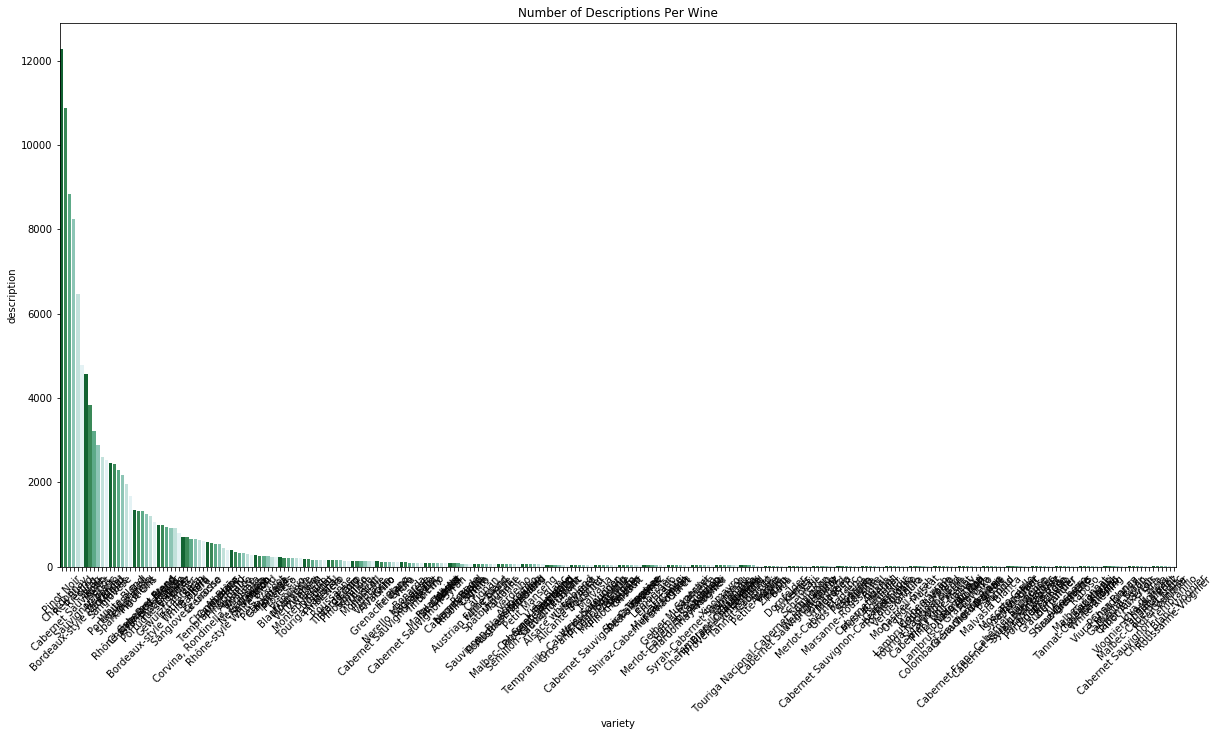

In [24]:
#df_cnt.set_index('variety')['description'].head(300)[::-1].plot(kind='bar', figsize=(15,5))
#plt.show()
#reload(sys)  
#sys.setdefaultencoding('utf8')
import matplotlib.pyplot as plt

x = df_cnt[df_cnt['description'] > 10]['variety']
y = df_cnt[df_cnt['description'] > 10]['description']


plt.figure(figsize=(20,10))

df_cnt.set_index('variety')
ax = sns.barplot(x=x,y=y,palette=  sns.color_palette("BuGn_r")).set_title("Number of Descriptions Per Wine");

#ax.set_xticklabels(rotation=30);
plt.xticks(rotation=45)
plt.show()

In [31]:
std=df_cnt.std()[0]

print "The standard deviation for count of descriptions is", std,"...this is pretty big"
#Again, the Standard Deviation is big for descriptions by wine.

The standard deviation for count of descriptions is 903.240762063 ...this is pretty big


I know that I need to cutoff the descriptions somewhere because prediction will be tough with too few. In order to figure out where to set the cutoff mark for which wines to include or exclude from my analysis, I want to understand the number of descriptions per variety a bit further. A quick .describe() shows that average amount of descriptions is 169, but the median is only 5. This is a pretty big discrepancy.  

In [17]:
df_cnt.describe() 

,description
count,707.000000
mean,169.666195
std,903.240762
min,1.000000
25%,2.000000
50%,5.000000
75%,26.500000
max,12277.000000


Below, I explore the bar graph a little more with different cuts to see where to cut off.

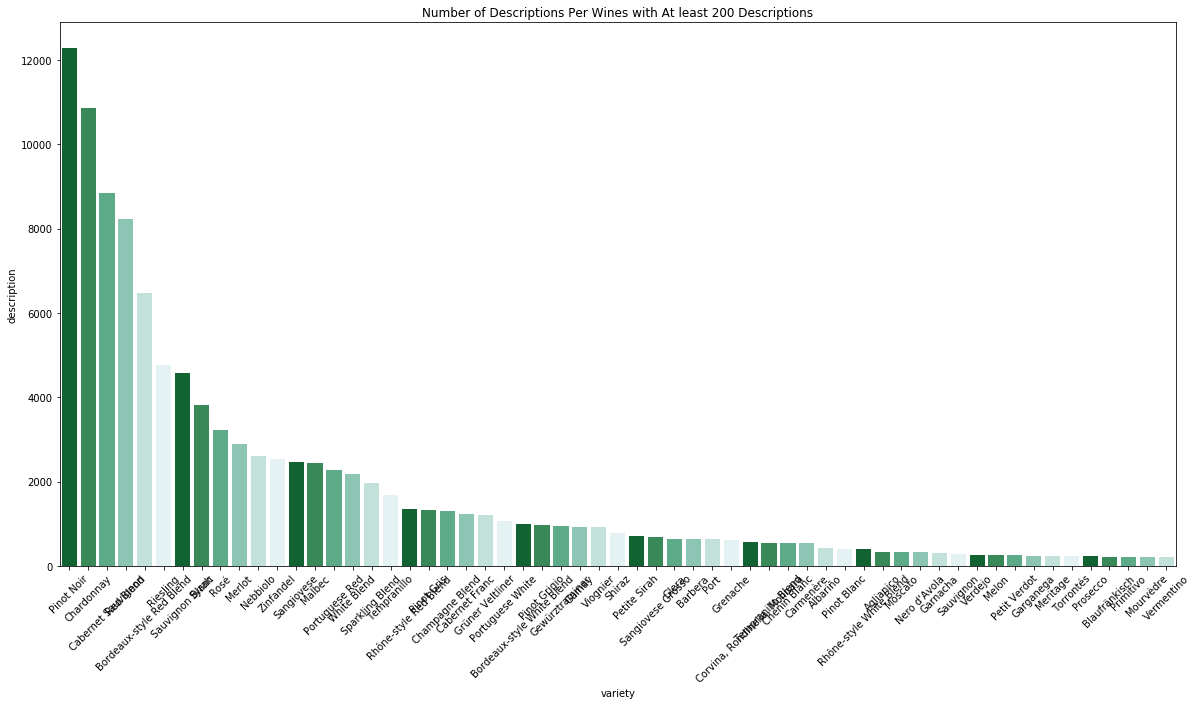

In [18]:
#df_cnt.set_index('variety')['description'].head(300)[::-1].plot(kind='bar', figsize=(15,5))
#plt.show()
import matplotlib.pyplot as plt


x = df_cnt[df_cnt['description'] >= 200]['variety']
y = df_cnt[df_cnt['description'] >= 200]['description']

plt.figure(figsize=(20,10))

df_cnt.set_index('variety')
ax = sns.barplot(x=x,y=y,palette=  sns.color_palette("BuGn_r")).set_title("Number of Descriptions Per Wines with At least 200 Descriptions");

#ax.set_xticklabels(rotation=30);
plt.xticks(rotation=45)
plt.show()

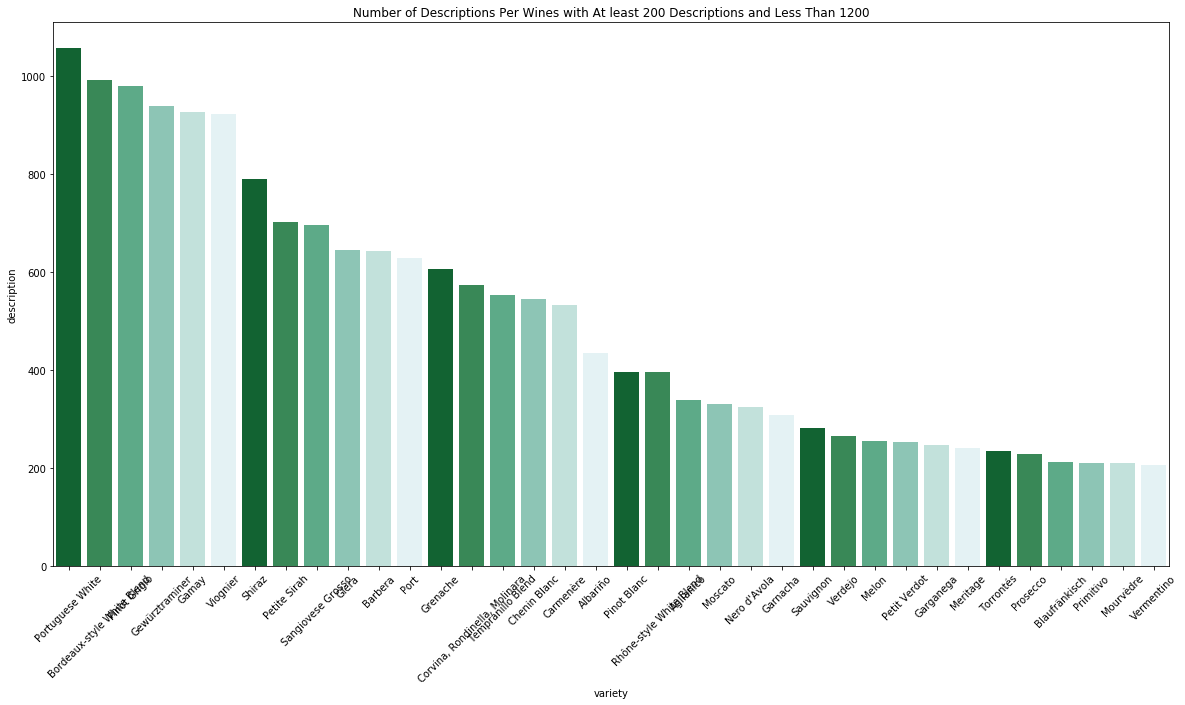

In [19]:
#df_cnt.set_index('variety')['description'].head(300)[::-1].plot(kind='bar', figsize=(15,5))
#plt.show()
import matplotlib.pyplot as plt


x = df_cnt[(df_cnt['description'] >= 200) &(df_cnt['description'] < 1200)  ]['variety']
y = df_cnt[(df_cnt['description'] >= 200) &(df_cnt['description'] < 1200) ]['description']

plt.figure(figsize=(20,10))

df_cnt.set_index('variety')
ax = sns.barplot(x=x,y=y,palette=  sns.color_palette("BuGn_r")).set_title("Number of Descriptions Per Wines with At least 200 Descriptions and Less Than 1200");

#ax.set_xticklabels(rotation=30);
plt.xticks(rotation=45)
plt.show()

In [33]:
df_cnt[(df_cnt['description'] >= 200)].tail()

,variety,description
461,Prosecco,229
56,Blaufränkisch,213
459,Primitivo,210
362,Mourvèdre,210
662,Vermentino,207


I'm going to try my analysis with at least 200 descriptions per wine type. If this is successful, it may be interesting to try the model on wine varieties with fewer descriptions. 

In [34]:
df_cnt = df_cnt.set_index('variety')

I'm removing the wines with less than 200 descriptions from my dataset

In [35]:
wine_list = []
for i in df_cnt[df_cnt['description'] >= 200].index:
    wine_list.append(i)


In [36]:
df_cln.head()

,country,description,points,price,province,region_1,region_2,variety,title,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Etna,NaN,White Blend,Nicosia 2013 Vulkà Bianco (Etna),Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,NaN,Portuguese Red,Quinta dos Avidagos 2011 Avidagos Red (Douro),Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Pinot Gris,Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,NaN,Riesling,St. Julian 2013 Reserve Late Harvest Riesling ...,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Sweet Cheeks


In [37]:
df_cln = df_cln[df_cln['variety'].isin(wine_list)]

In [38]:
wine_list = map(lambda x:x.lower(),wine_list)

In [39]:
df_cln.head()

,country,description,points,price,province,region_1,region_2,variety,title,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Etna,NaN,White Blend,Nicosia 2013 Vulkà Bianco (Etna),Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,NaN,Portuguese Red,Quinta dos Avidagos 2011 Avidagos Red (Douro),Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Pinot Gris,Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,NaN,Riesling,St. Julian 2013 Reserve Late Harvest Riesling ...,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Sweet Cheeks


In [40]:
print "there are a total of ", df_cln.variety.nunique(), "types of wine that will be used in this analysis"

there are a total of  59 types of wine that will be used in this analysis


In [41]:
wine_list.append('zin')

In [42]:
wine_list

['pinot noir',
 'chardonnay',
 'cabernet sauvignon',
 'red blend',
 'bordeaux-style red blend',
 'riesling',
 'sauvignon blanc',
 'syrah',
 'ros\xc3\xa9',
 'merlot',
 'nebbiolo',
 'zinfandel',
 'sangiovese',
 'malbec',
 'portuguese red',
 'white blend',
 'sparkling blend',
 'tempranillo',
 'rh\xc3\xb4ne-style red blend',
 'pinot gris',
 'champagne blend',
 'cabernet franc',
 'gr\xc3\xbcner veltliner',
 'portuguese white',
 'bordeaux-style white blend',
 'pinot grigio',
 'gew\xc3\xbcrztraminer',
 'gamay',
 'viognier',
 'shiraz',
 'petite sirah',
 'sangiovese grosso',
 'glera',
 'barbera',
 'port',
 'grenache',
 'corvina, rondinella, molinara',
 'tempranillo blend',
 'chenin blanc',
 'carmen\xc3\xa8re',
 'albari\xc3\xb1o',
 'pinot blanc',
 'rh\xc3\xb4ne-style white blend',
 'aglianico',
 'moscato',
 "nero d'avola",
 'garnacha',
 'sauvignon',
 'verdejo',
 'melon',
 'petit verdot',
 'garganega',
 'meritage',
 'torront\xc3\xa9s',
 'prosecco',
 'blaufr\xc3\xa4nkisch',
 'primitivo',
 'mourv\x

## Preparing the Descriptions Data Set for Modeling

First, I just want to do some housekeeping to make all the text lowercase as well as get add in the length of the descriptions per observation.

In [43]:
df_cln['description'] = df_cln[['description']].apply(lambda x: x.str.lower())
df_cln['country'] = df_cln[['country']].apply(lambda x: x.str.lower())
df_cln['province'] = df_cln[['province']].apply(lambda x: x.str.lower())
df_cln['region_1'] = df_cln[['region_1']].apply(lambda x: x.str.lower())
df_cln['variety'] = df_cln[['variety']].apply(lambda x: x.str.lower())
df_cln['title'] = df_cln[['title']].apply(lambda x: x.str.lower())
df_cln['winery'] = df_cln[['winery']].apply(lambda x: x.str.lower())

#Make all the text in this dataset lower case. There are definitely ways to make the above code more efficient. 


I just want to make sure all of these descriptions look more or less the same, that some wines aren't shorter or longer than the other, thus giving them an unfair bias for prediction.

In [44]:
df_cln['length'] =  df_cln['description'].str.len()


In [45]:
df_cln.head(3)

,country,description,points,price,province,region_1,region_2,variety,title,winery,length
0,italy,"aromas include tropical fruit, broom, brimston...",87,NaN,sicily & sardinia,etna,NaN,white blend,nicosia 2013 vulkà bianco (etna),nicosia,172
1,portugal,"this is ripe and fruity, a wine that is smooth...",87,15.0,douro,NaN,NaN,portuguese red,quinta dos avidagos 2011 avidagos red (douro),quinta dos avidagos,227
2,us,"tart and snappy, the flavors of lime flesh and...",87,14.0,oregon,willamette valley,Willamette Valley,pinot gris,rainstorm 2013 pinot gris (willamette valley),rainstorm,186


Looking at the bar graph below, it looks like the length of descriptions is pretty standard across the now limited dataset. This is good! 

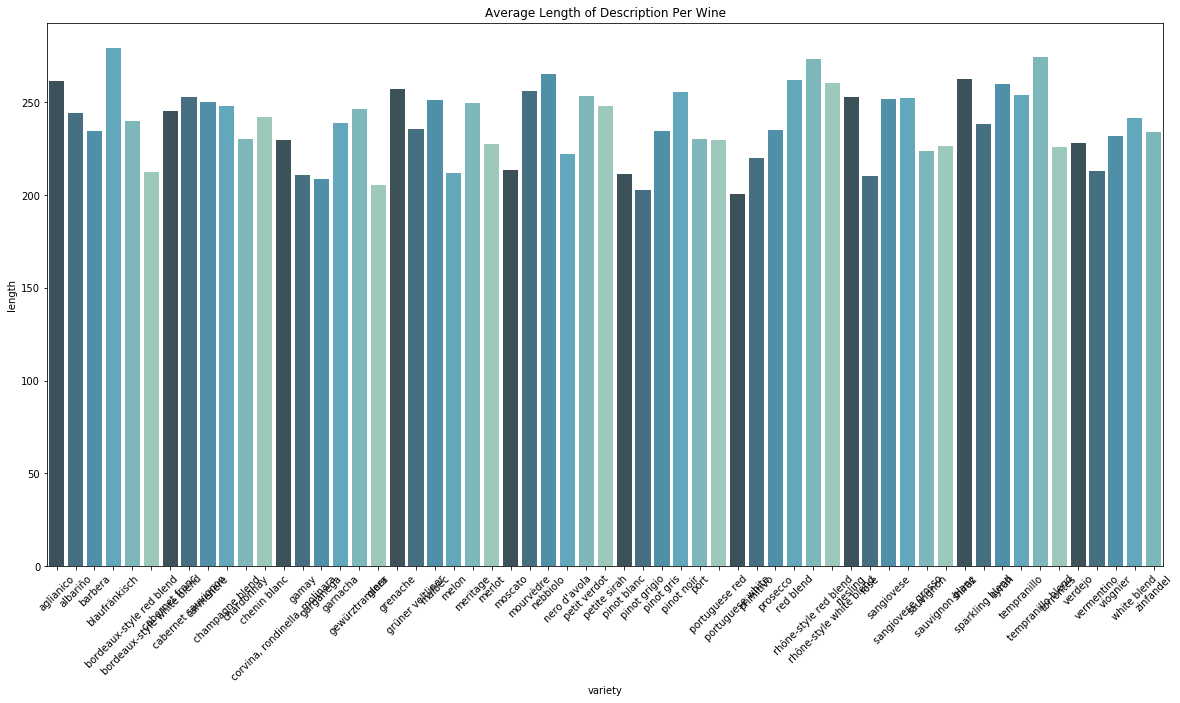

In [46]:
#df_cln[['variety','length']].groupby(by='variety').mean()['length']




x = df_cln[['variety','length']].groupby(by='variety').mean().index
y = df_cln[['variety','length']].groupby(by='variety').mean()['length']

plt.figure(figsize=(20,10))

ax = sns.barplot(x=x,y=y,palette=  sns.color_palette("GnBu_d")).set_title('Average Length of Description Per Wine');

#ax.set_xticklabels(rotation=30);
plt.xticks(rotation=45)
plt.show()

# Reading through some of the descriptions below, it becomes clear that I need to:

* Remove whitespace
* Tokenize the strings
* Remove stopwords
* Remove the actual name of wines within the description. 
* Find the top words for some of the more obvious wines to see if they make sense
 


In [47]:
pd.options.display.max_colwidth = 300
df_cln.description.head(5)

0                                                                                 aromas include tropical fruit, broom, brimstone and dried herb. the palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.
1                          this is ripe and fruity, a wine that is smooth while still structured. firm tannins are filled out with juicy red berry fruits and freshened with acidity. it's  already drinkable, although it will certainly be better from 2016.
2                                                                   tart and snappy, the flavors of lime flesh and rind dominate. some green pineapple pokes through, with crisp acidity underscoring the flavors. the wine was all stainless-steel fermented.
3                                                      pineapple rind, lemon pith and orange blossom start off the aromas. the palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringe

### Removing Whitespace


In [48]:
df_cln['description'] = df_cln[['description']].apply(lambda x: x.str.strip())
df_cln['variety'] = df_cln[['variety']].apply(lambda x: x.str.strip())

### Tokenizing the description

In [49]:
df_cln['words'] = df_cln.description.str.strip().str.split('[\W_]+')
df_cln.head(1)

,country,description,points,price,province,region_1,region_2,variety,title,winery,length,words
0,italy,"aromas include tropical fruit, broom, brimstone and dried herb. the palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",87,NaN,sicily & sardinia,etna,NaN,white blend,nicosia 2013 vulkà bianco (etna),nicosia,172,"[aromas, include, tropical, fruit, broom, brimstone, and, dried, herb, the, palate, isn, t, overly, expressive, offering, unripened, apple, citrus, and, dried, sage, alongside, brisk, acidity, ]"


### Removing Stopwords & Explicit Mentions of Wine Names

In [50]:
from nltk.corpus import stopwords
stop = stopwords.words('english')


In [51]:
print wine_list


['pinot noir', 'chardonnay', 'cabernet sauvignon', 'red blend', 'bordeaux-style red blend', 'riesling', 'sauvignon blanc', 'syrah', 'ros\xc3\xa9', 'merlot', 'nebbiolo', 'zinfandel', 'sangiovese', 'malbec', 'portuguese red', 'white blend', 'sparkling blend', 'tempranillo', 'rh\xc3\xb4ne-style red blend', 'pinot gris', 'champagne blend', 'cabernet franc', 'gr\xc3\xbcner veltliner', 'portuguese white', 'bordeaux-style white blend', 'pinot grigio', 'gew\xc3\xbcrztraminer', 'gamay', 'viognier', 'shiraz', 'petite sirah', 'sangiovese grosso', 'glera', 'barbera', 'port', 'grenache', 'corvina, rondinella, molinara', 'tempranillo blend', 'chenin blanc', 'carmen\xc3\xa8re', 'albari\xc3\xb1o', 'pinot blanc', 'rh\xc3\xb4ne-style white blend', 'aglianico', 'moscato', "nero d'avola", 'garnacha', 'sauvignon', 'verdejo', 'melon', 'petit verdot', 'garganega', 'meritage', 'torront\xc3\xa9s', 'prosecco', 'blaufr\xc3\xa4nkisch', 'primitivo', 'mourv\xc3\xa8dre', 'vermentino', 'zin']


In [52]:
df_cln['cln_words'] = df_cln['words'].apply(lambda x: [item.lower() for item in x if item not in wine_list])

In [53]:
df_cln['cln_words'] = df_cln['cln_words'].apply(lambda x: [item for item in x if item not in stop])

### Exploring which are the top words per wine. 

Since it's hard to know whether or not a text feature will be predictive, I'm just going to take a look at the top terms per wine variety to see if it's what I expect. 

In [54]:
df_cln.head(1)

,country,description,points,price,province,region_1,region_2,variety,title,winery,length,words,cln_words
0,italy,"aromas include tropical fruit, broom, brimstone and dried herb. the palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",87,NaN,sicily & sardinia,etna,NaN,white blend,nicosia 2013 vulkà bianco (etna),nicosia,172,"[aromas, include, tropical, fruit, broom, brimstone, and, dried, herb, the, palate, isn, t, overly, expressive, offering, unripened, apple, citrus, and, dried, sage, alongside, brisk, acidity, ]","[aromas, include, tropical, fruit, broom, brimstone, dried, herb, palate, overly, expressive, offering, unripened, apple, citrus, dried, sage, alongside, brisk, acidity, ]"


In [55]:
rows = list()
for row in df_cln[['variety', 'cln_words']].iterrows():
    r = row[1]
    for word in r.cln_words:
        rows.append((r.variety, word))

words = pd.DataFrame(rows, columns=['variety', 'word'])
words.head()

,variety,word
0,white blend,aromas
1,white blend,include
2,white blend,tropical
3,white blend,fruit
4,white blend,broom


In [56]:
words = words[words.word.str.len() > 0]
#Removing any white spaces that may still be hiding in there


,variety,word
0,white blend,aromas
1,white blend,include
2,white blend,tropical
3,white blend,fruit
4,white blend,broom


Now I am outputting what the top words per wine are. A quick look seems to show what you'd expect (eg. fruit for Zinfandel, cherry for others) 

In [57]:
counts_word = words.groupby('variety').word.value_counts().to_frame().rename(columns={'word':'number_of_words'})
def pretty_plot_top_n(series, top_n=10, index_level=0):
    r = series\
    .groupby(level=index_level)\
    .nlargest(top_n)\
    .reset_index(level=index_level, drop=True)
    return r.to_frame()


pretty_plot_top_n(counts_word['number_of_words'])

number_of_words
variety     word                       
aglianico   black                   241
            aromas                  217
            tannins                 211
            wine                    174
            cherry                  167
            palate                  167
            spice                   159
            fruit                   147
            drink                   100
            dark                     99
albariño    flavors                 378
            aromas                  291
            finish                  260
            apple                   232
            palate                  210
            citrus                  170
            peach                   149
            acidity                 137
            wine                    136
            white                   132
barbera     wine                    342
            aromas                  336
            cherry                  311
            black                   306
            fruit                   305
            palate                  264
            acidity                 242
            flavors                 236
            tannins                 208
            spice                   198
...                                 ...
viognier    flavors                 564
            wine                    445
            fruit                   359
            finish                  298
            peach                   280
            palate                  270
            aromas                  258
            acidity                 239
            white                   206
            apricot                 191
white blend wine                   1207
            blend                  1113
            flavors                 995
            white                   933
            aromas                  913
            fruit                   868
            palate                  800
            finish                  623
            acidity                 615
            apple                   600
zinfandel   wine                   1467
            flavors                1436
            fruit                   793
            black                   655
            blackberry              619
            tannins                 608
            cherry                  595
            finish                  585
            ripe                    558
            pepper                  542

[590 rows x 1 columns]

# Next  Steps

* Explore stemming so words like "earth" and "earthy' are treated as the same word
* Double check that there isn't any punctuation to remove. The regular expressions should only have included words but I should confirm this.
* Vectorize the descriptions using tfidf  account for words like "flavor" that appear in almost every single description. Also an important step to prep for the modeling phase.
* Actually decide on and execute the model!